In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
from atl_module.geospatial_utils.raster_interaction import random_raster_gdf,subset_gebco
from atl_module import GebcoUpscaler
from atl_module.kriging import krige_bathy,_relaxation_dart_throwing
from atl_module.error_calc import raster_RMSE_blocked
from atl_module.kalman import gridded_kalman_update
from atl_module.geospatial_utils.raster_interaction import query_from_lines
import geopandas as gpd
import pandas as pd

In [3]:
truthraster_path = '../data/test_sites/florida_keys/in-situ-dem/truth.vrt'

<AxesSubplot:>

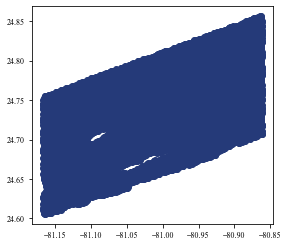

In [4]:
gdf = random_raster_gdf(truthraster_path,20000)
gdf = gdf.rename(columns={'truth raster elevation':'sf_elev_MSL'})
gdf.plot()

In [5]:
gdf.to_file('../data/truthraster_sampling/random_pts.gpkg')
gpd.read_file('../data/truthraster_sampling/random_pts.gpkg').to_file('../data/truthraster_sampling/all_bathy_pts.gpkg')
gdf = gdf.to_crs(gdf.estimate_utm_crs())

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [6]:
gdf = gdf.rename(columns={'truth raster elevation':'sf_elev_MSL'})


In [7]:
hres = 50
subset_gebco('../data/truthraster_sampling',bathy_pts=gdf,epsg_no=gdf.crs.to_epsg(),hres=hres)

[D 220926 23:46:41 raster_interaction:149] GEBCO subset raster written to ../data/truthraster_sampling/bilinear.tif, with CRS EPSG:32617


In [8]:
# gdf = gdf.rename(columns={'truth raster elevation':'sf_elev_MSL'})


In [9]:
gdf = gdf[gdf.sf_elev_MSL < 0]

In [10]:
import rasterio 
import matplotlib.pyplot as plt
from rasterio.plot import show as rastershow

In [11]:
# with rasterio.open('../data/test_sites/florida_keys/in-situ-DEM/truth.vrt') as femaras:
#     fig, ax = plt.subplots(figsize=(20, 12))
#     ax.set_xlabel(f"Degrees longitude in {femaras.crs}")
#     ax.set_ylabel(f"Degrees latitude in {femaras.crs}")
#     # ax.set_title("")
#     # cx.add_basemap(ax,source=cx.providers.OpenTopoMap,crs=femaras.crs)
#     image_hidden = ax.imshow(
#         femaras.read(1, masked=True),
#         cmap="inferno",
#     )
#     rastershow(femaras, cmap="inferno", ax=ax)

#     fig.colorbar(image_hidden, ax=ax)

# fig.savefig('../document/figures/truthraster_sampling_rasterplot.pdf',dpi=500,bbox_inches='tight')

In [ ]:
krige_bathy(kr_model='uk',folderpath='../data/truthraster_sampling',npts=2000,variogram_model='spherical',pts_gdf_all=gdf,crs=gdf.crs,samplemethod='dart', variogram_parameters={
    'range':10000,
    'nugget':0.7,
    'sill':23
},
)
# .kriging(1500,kr_model='uk',samplemethod = 'dart')

[D 220926 23:46:41 kriging:29] The types of the numpy array that is sent to PDAL poisson dart throwing are: (numpy.record, [('Y', '<f8'), ('X', '<f8'), ('Z', '<f4')])
[D 220926 23:46:41 kriging:35] 2000 points remaining after relaxation dart throwing culling
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[D 220926 23:46:42 kriging:79] 2000 points selected with dart written to ../data/truthraster_sampling/kriging_pts


Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 22.3
Full Sill: 23.0
Range: 10000
Nugget: 0.7 

Calculating statistics on variogram model fit...


In [ ]:
gdf_sampled = gpd.read_file('../data/truthraster_sampling/kriging_pts/')


In [ ]:
ax = gdf_sampled.plot(figsize=(20, 12))
ax.get_figure().savefig('../document/figures/pts_sampled_from_truthraster.pdf')

In [ ]:
bilinear_rmse = raster_RMSE_blocked(truth_raster_path=truthraster_path,measured_rasterpath='../data/truthraster_sampling/bilinear.tif')

In [ ]:
assumed_gebco_variance = 1.5

In [ ]:
purekriged_rmse = raster_RMSE_blocked(truth_raster_path=truthraster_path,measured_rasterpath='../data/truthraster_sampling/kriging_output.tif')
gridded_kalman_update('../data/truthraster_sampling/kalman_update.tif','../data/truthraster_sampling/bilinear.tif','../data/truthraster_sampling/kriging_output.tif',1.5)
kalman_updated_rmse =raster_RMSE_blocked(truth_raster_path=truthraster_path,measured_rasterpath='../data/truthraster_sampling/kalman_update.tif')

old val to beat: 2.358246

# sampling along lines

In [ ]:
tracklines = gpd.read_file('../data/test_sites/florida_keys/tracklines/')
truthsampler = lambda x: query_from_lines(x,truthraster_path,1)

In [ ]:
sampled_lines = tracklines.geometry.apply(truthsampler).apply(pd.Series)

In [ ]:
xvals = sampled_lines[0].apply(pd.Series).to_numpy().flatten()
yvals = sampled_lines[1].apply(pd.Series).to_numpy().flatten()
zvals = sampled_lines[2].apply(pd.Series).to_numpy().flatten()

In [ ]:
points_along_lines = gpd.GeoDataFrame(zvals,geometry=gpd.points_from_xy(xvals,yvals),crs='EPSG:4326')
points_along_lines = points_along_lines.to_crs(points_along_lines.estimate_utm_crs())

In [ ]:
points_along_lines = points_along_lines.rename(columns={0:'sf_elev_MSL'}).dropna()
points_along_lines = points_along_lines[points_along_lines.sf_elev_MSL < 0]

In [ ]:
points_along_lines.to_file('../data/truthraster_sampling/points_along_lines.gpkg')

In [ ]:
hres = 50
subset_gebco('../data/truthraster_sampling',bathy_pts=points_along_lines,epsg_no=points_along_lines.crs.to_epsg(),hres=hres)

In [ ]:
# this is extremely ugly, but the kriging function requires a points path with this specific name
krige_bathy(kr_model='uk',folderpath='../data/truthraster_sampling',npts=2000,variogram_model='spherical',pts_gdf_all=points_along_lines,crs=points_along_lines.crs,samplemethod='dart', variogram_parameters={
    'range':10000,
    'nugget':0.7,
    'sill':23
},
)

In [ ]:
purekriged_rmse_lines = raster_RMSE_blocked(truth_raster_path=truthraster_path,measured_rasterpath='../data/truthraster_sampling/kriging_output.tif')

gridded_kalman_update('../data/truthraster_sampling/kalman_update.tif','../data/truthraster_sampling/bilinear.tif','../data/truthraster_sampling/kriging_output.tif',1.5)
kalman_updated_rmse_lines =raster_RMSE_blocked(truth_raster_path=truthraster_path,measured_rasterpath='../data/truthraster_sampling/kalman_update.tif')

In [ ]:
rmse_dict = {
    f'Truth vs {hres}m bilinear resampling of GEBCO':bilinear_rmse,
             # 'Truth vs Kriged raster output':purekriged_rmse,
             # 'Truth vs GEBCO+Kriged raster':kalman_updated_rmse,
            'Truth Vs kriged Raster - Sampling along lines':purekriged_rmse_lines,
            'Gebco updated - sampling along lines':kalman_updated_rmse_lines
}
truthraster_sampling_table = pd.DataFrame.from_dict(rmse_dict,orient='columns').T

truthraster_sampling_table.style.to_latex('../document/tables/truth_raster_sample_error.tex',caption='Error between the various data products',label='tab:rmse-truth-raster-sampled')

truthraster_sampling_table